## Missing Data Examples

In this notebook we will look at the effects missing data can have on conclusions you can draw from data.  We will also go over some practical implementations for linear regressions in Python

In [26]:
# Includes and Standard Magic...
### Standard Magic and startup initializers.

# Load Numpy
import numpy as np
# Load MatPlotLib
import matplotlib
import matplotlib.pyplot as plt
# Load Pandas
import pandas as pd
# Load SQLITE
import sqlite3
# Load Stats
from scipy import stats

# This lets us show plots inline and also save PDF plots if we want them
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
matplotlib.style.use('fivethirtyeight')

# These two things are for Pandas, it widens the notebook and lets us display data easily.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Show a ludicrus number of rows and columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

For this work we will be using data from: Generalized body composition prediction equation for men using simple measurement techniques", K.W. Penrose, A.G. Nelson, A.G. Fisher, FACSM, Human Performance research Center, Brigham Young University, Provo, Utah 84602 as listed in Medicine and Science in Sports and Exercise, vol. 17, no. 2, April 1985, p. 189.

[Data availabe here.](http://staff.pubhealth.ku.dk/~tag/Teaching/share/data/Bodyfat.html)


In [27]:
# Load the Penrose Data
df_penrose = pd.read_csv("./data/bodyfat.csv")

In [28]:
display(df_penrose.head())
# observations = ['Neck', 'Chest', 'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist']
observations = ['Age', 'Neck', 'Forearm', 'Wrist']

,Density,bodyfat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [29]:
len(df_penrose)

252

Let's do some basic scatter plots first to see what's going on.

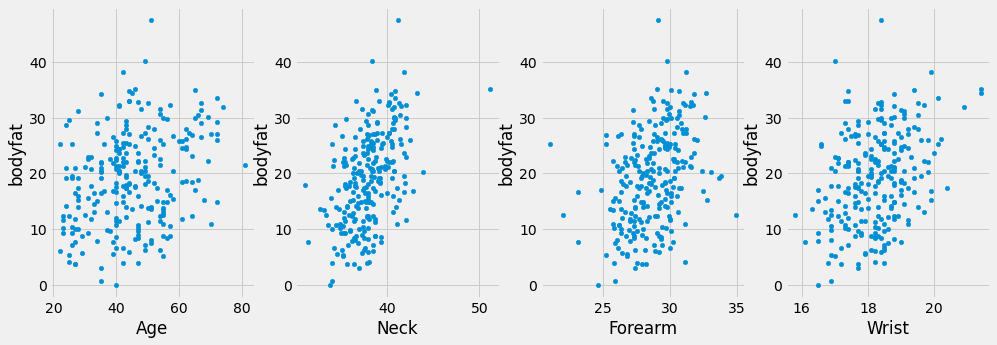

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,o in enumerate(observations):
    df_penrose.plot.scatter(x=o, y='bodyfat', ax=ax[i])

Let's say we want to look at some linear regressions of single variables to see what is going on!  So let's plot some regression lines.  Note that there are at least a few different ways -- [linregress](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html), [polyfit](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html), and [statsmodels](https://www.statsmodels.org/stable/index.html).

Here's a good article about it [Data science with Python: 8 ways to do linear regression and measure their speed](https://www.freecodecamp.org/news/data-science-with-python-8-ways-to-do-linear-regression-and-measure-their-speed-b5577d75f8b/).

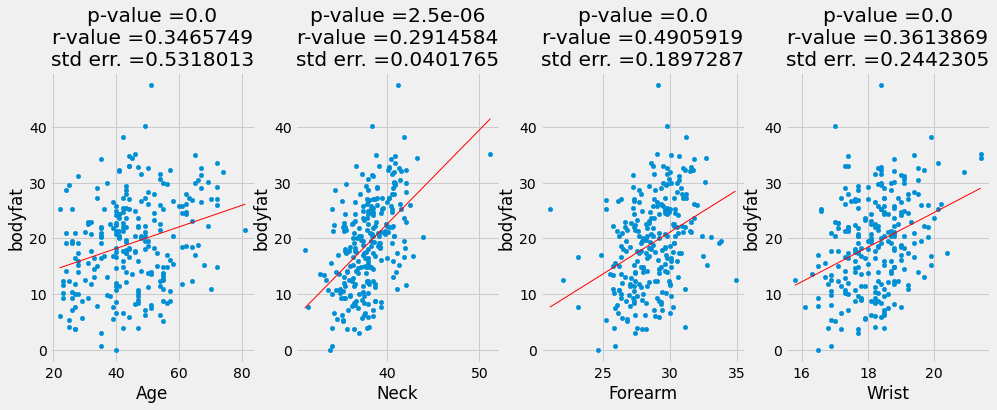

In [35]:
# Let's do a basic Linear Regression on a Single Variable.
# Note that linregress p-value is whether or not the slope is 0, not if the correlation is significant.
fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,o in enumerate(observations):
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_penrose[o],df_penrose['bodyfat'])

    df_penrose.plot.scatter(x=o, y='bodyfat', title=diag_str, ax=ax[i])
    
    # Make points and line
    pts = np.linspace(df_penrose[o].min(), df_penrose[o].max(), 500)
    line = slope * pts + intercept
    ax[i].plot(pts, line, lw=1, color='red')
    
    # Put the results on our plot.
    diag_str = "p-value =" + str(round(p_value, 7)) + "\n" + "r-value =" + str(round(r_value, 7)) + "\nstd err. =" + str(round(std_err, 7))

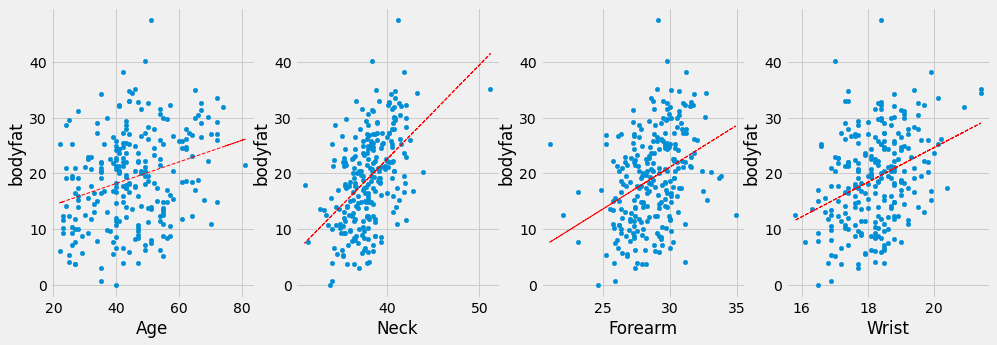

In [36]:
# Let's try to fit a linear model with PolyFit.

fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,o in enumerate(observations):
    x1, intercept = np.polyfit(df_penrose[o],df_penrose['bodyfat'], 1)
    line = x1 * df_penrose[o] + intercept
    df_penrose.plot.scatter(x=o, y='bodyfat', ax=ax[i])
    ax[i].plot(df_penrose[o], line, lw=1, ls='--', color='red')

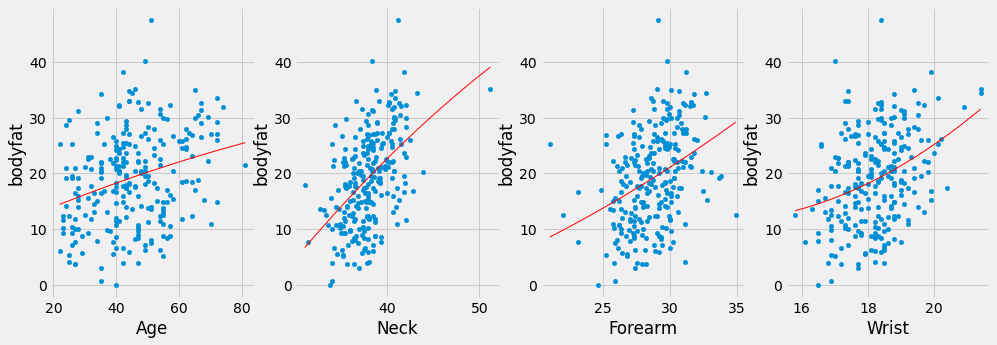

In [37]:
# Let's try fitting a degree 2 polynomial with polyfit.

fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,o in enumerate(observations):
    
    # Fit the polynomial.
    x2, x1, intercept = np.polyfit(df_penrose[o],df_penrose['bodyfat'], 2)

    # Plot our points.
    df_penrose.plot.scatter(x=o, y='bodyfat', ax=ax[i])
    
    # Plot the Regression Line..
    pts = np.linspace(df_penrose[o].min(), df_penrose[o].max(), 500)
    line = x2 * pts**2 + x1 * pts + intercept
    ax[i].plot(pts, line, lw=1, ls='-', color='red')

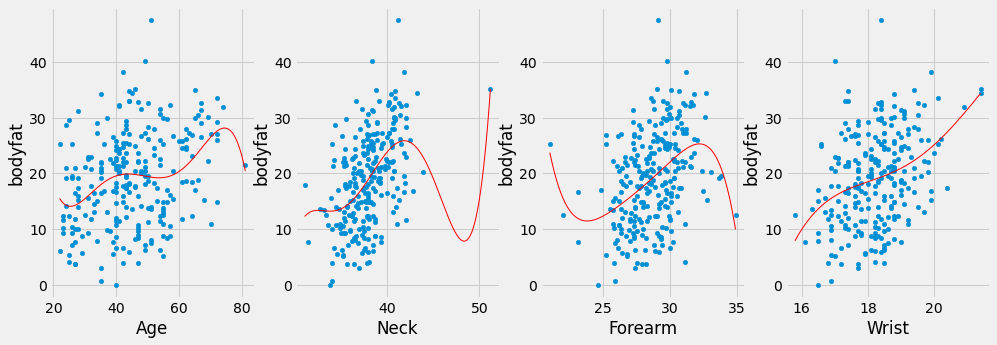

In [40]:
# Let's try fitting a degree 5 polynomial with polyfit.

fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,o in enumerate(observations):
    
    # Fit the polynomial.
    x5, x4, x3, x2, x1, intercept = np.polyfit(df_penrose[o],df_penrose['bodyfat'], 5)

    # Plot our points.
    df_penrose.plot.scatter(x=o, y='bodyfat', ax=ax[i])
    
    # Plot the Regression Line..
    pts = np.linspace(df_penrose[o].min(), df_penrose[o].max(), 500)
    line = x5 * pts**5 + x4 * pts**4 + x3 * pts**3 + x2 * pts**2 + x1 * pts + intercept
    ax[i].plot(pts, line, lw=1, ls='-', color='red')

What happens if we start to remove parts of the data -- is the relationship still as strong?

We can use the [pandas sample command](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) to remove some of the dataframe.

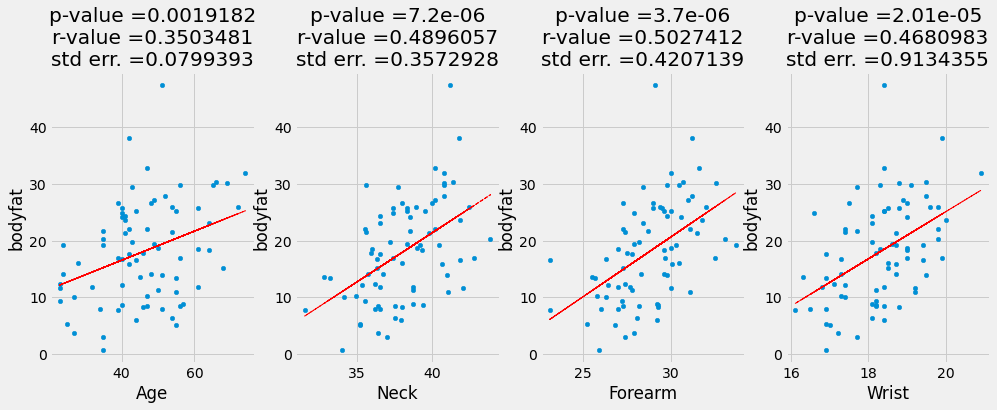

In [9]:
# Let's do a basic Linear Regression on a Single Variable.
# Note that linregress p-value for the null-hyp that slope = 0.
df_test = df_penrose.sample(frac=0.30, replace=False)
fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,o in enumerate(observations):
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_test[o],df_test['bodyfat'])
    line = slope * df_test[o] + intercept
    diag_str = "p-value =" + str(round(p_value, 7)) + "\n" + "r-value =" + str(round(r_value, 7)) + "\nstd err. =" + str(round(std_err, 7))
    df_test.plot.scatter(x=o, y='bodyfat', title=diag_str, ax=ax[i])
    ax[i].plot(df_test[o], line, lw=1, ls='--', color='red')

If we want to determine if these correlations are significant under the missing data then we need to run bootstrap samples and see what happens.



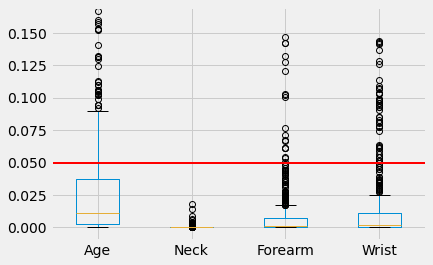

In [10]:
results = {o:[] for o in observations}
for i,o in enumerate(observations):
    for t in range(500):
        df_test = df_penrose.sample(frac=0.30, replace=False)
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_test[o],df_test['bodyfat'])
        #r,p = stats.pearsonr(df_test[o], df_test['bodyfat'])
        results[o].append(p_value)
rs = pd.DataFrame(results)
ax = rs.boxplot()
ax.set_ylim([-0.01,0.17])
ax.axhline(y=0.05, lw=2, color='red')
plt.show()

## A More Complicated example with Statsmodels.

Statsmodels (you'll likely need to install it) gives a much more R-like interface to linear modeling.  You can read [more about it here](https://www.statsmodels.org/stable/index.html).

In [11]:
import statsmodels.api as sm

In [12]:
df_ind = df_penrose[['Neck', 'Wrist']]
df_target = df_penrose['bodyfat']

In [13]:
X = df_ind
y = df_target

# Note the difference in argument order
# Call: endog, then exog (dependent, indepenednt)
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model
# Print out the statistics
model.summary()
#fig, ax = plt.subplots(figsize=(12,8))
#fig = sm.graphics.plot_partregress(endog="bodyfat", exog_i=['Abdomen', 'Neck'], exog_others='', data=df_penrose)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                bodyfat   R-squared (uncentered):                   0.868
Model:                            OLS   Adj. R-squared (uncentered):              0.867
Method:                 Least Squares   F-statistic:                              823.5
Date:                Wed, 21 Oct 2020   Prob (F-statistic):                   9.64e-111
Time:                        14:23:37   Log-Likelihood:                         -868.15
No. Observations:                 252   AIC:                                      1740.
Df Residuals:                     250   BIC:                                      1747.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Neck           1.6874      0.295      5.714      0.000       1.106       2.269
Wrist         -2.4602      0.616     -3.995      0.000      -3.673      -1.247
==============================================================================
Omnibus:                        2.850   Durbin-Watson:                   1.490
Prob(Omnibus):                  0.241   Jarque-Bera (JB):                2.309
Skew:                           0.107   Prob(JB):                        0.315
Kurtosis:                       2.583   Cond. No.                         60.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can also use the [single regressor plot](https://tedboy.github.io/statsmodels_doc/generated/statsmodels.graphics.api.plot_partregress.html#statsmodels.graphics.api.plot_partregress).

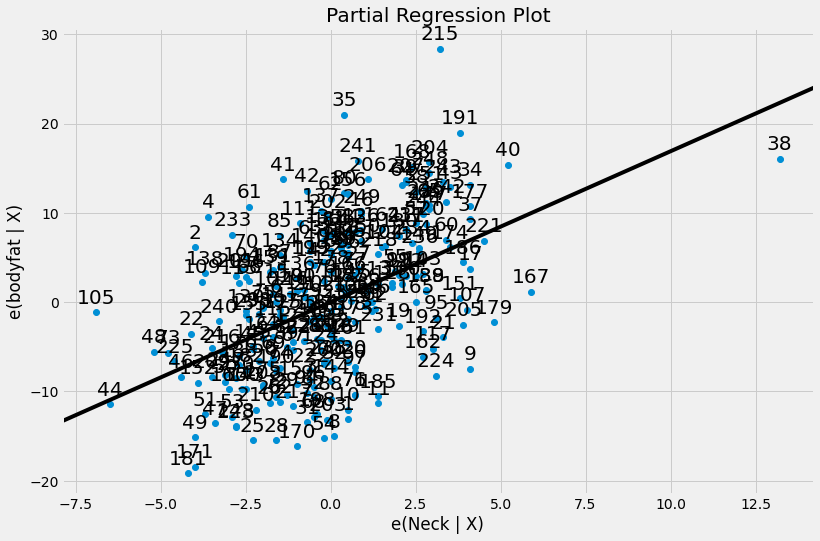

In [14]:
from statsmodels.graphics.regressionplots import plot_partregress
fig, ax = plt.subplots(figsize=(12,8))
plot_partregress(endog='bodyfat', exog_i='Neck', exog_others='', data=df_penrose, ax=ax)
plt.show()

If we have multiple elements in our regression then we need to use a different plot.

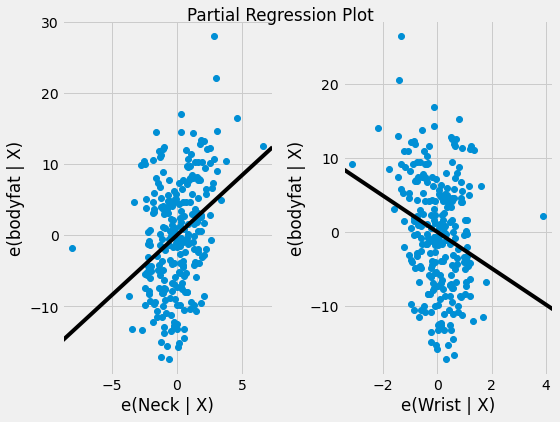

In [15]:
# Multiple regression plot
from statsmodels.graphics.regressionplots import plot_partregress_grid
fig = plt.figure(figsize=(8, 6))
plot_partregress_grid(model, fig=fig)
plt.show()

Another way to work with regressions and their plots is using the [Seaborn Regression Package](https://seaborn.pydata.org/tutorial/regression.html)

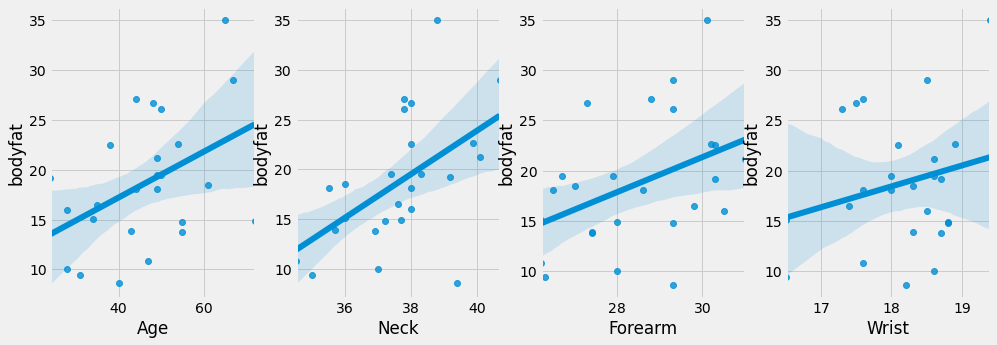

In [16]:
# Another way to do simple exploratory plots
import seaborn as sns
df_test = df_penrose.sample(frac=0.10, replace=False)
fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,o in enumerate(observations):
    sns.regplot(x=o, y='bodyfat', data=df_test, ax=ax[i])
    #g.axes.set_xlim(df_test[o].min()*.95,df_test[o].max()*1.05)
    


Another nice simulator to play with is [this one](https://ndirienzo.shinyapps.io/linear_regression_sim/) which is from [Prof. Nicholas DiRienzo](https://ischool.arizona.edu/people/nicholas-dirienzo) from ASU's School of Information 